In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

dirs = sorted(os.listdir("./outs"))
list(enumerate(dirs))

[(0, '.gitignore'),
 (1, '.ipynb_checkpoints'),
 (2, '180705_unet'),
 (3, '180709_unetsh1_b32_strided'),
 (4, '180710_unetsh3_b32'),
 (5, '180711_unetsh3BN_pool'),
 (6, '180712_unetres_IN_b16'),
 (7, '180713_unetres_GN_b16'),
 (8, '180713_unetres_IN_b16'),
 (9, '180713_unetres_IN_b16_b050999'),
 (10, '180714_unetres_GN_b16_pretrain'),
 (11, '180717_fusion_BN_fold3'),
 (12, '180720_unet_pool_upsample_fold1'),
 (13, '180720_unet_pool_upsample_fold2'),
 (14, '180720_unet_pool_upsample_fold3'),
 (15, '180720_unet_pool_upsample_fold4'),
 (16, '180727_unet_strided_IN_BCE_aug30_fold1'),
 (17, '180802_exfuseUnet'),
 (18, '180802_exfusetest'),
 (19, '180806_unetgcnecre_fold4'),
 (20, 'dw_viewer.ipynb'),
 (21, 'test')]

In [2]:
target_dir = dirs[16]
import torch
import torch.nn as nn
ckpoint = torch.load("./outs/" + target_dir + "/models.pth.tar")

from models.unet import Unet2D as Model
#from models.UnetExFuse import UnetGCNECRE as Model

model = nn.DataParallel(Model(feature_scale=4, is_pool=False, norm=nn.InstanceNorm2d))
model.load_state_dict(ckpoint["network"])
model = model.module

model_outputs = []
def save_model_output(self, input_, output_):
    model_outputs.append(output_)

model.conv1.register_forward_hook(save_model_output)    
model.conv2.register_forward_hook(save_model_output)    
model.conv3.register_forward_hook(save_model_output)    
model.conv4.register_forward_hook(save_model_output)    
    
#model.gcn1.register_forward_hook(save_model_output)
#model.gcn2.register_forward_hook(save_model_output)
#model.gcn3.register_forward_hook(save_model_output)
#model.gcn4.register_forward_hook(save_model_output)

model.center.register_forward_hook(save_model_output)

model.up_concat4.register_forward_hook(save_model_output)
model.up_concat3.register_forward_hook(save_model_output)
model.up_concat2.register_forward_hook(save_model_output)
model.up_concat1.register_forward_hook(save_model_output)
model.final.register_forward_hook(save_model_output)
model.final.register_forward_hook(save_model_output)


from NucleusLoader import NucleusLoader
test_path = "/data/00_Nuclues_segmentation/00_data/2D/Test_FL"
test_loader = NucleusLoader(test_path, 1,
                            cpus=8,
                            shuffle=False, drop_last=False)
# model

In [3]:
for i, t, f in test_loader:
    o = model(i)
    print(o.shape)
    print("Done"); break

torch.Size([1, 1, 448, 448])
Done


In [4]:
len(model_outputs)

11

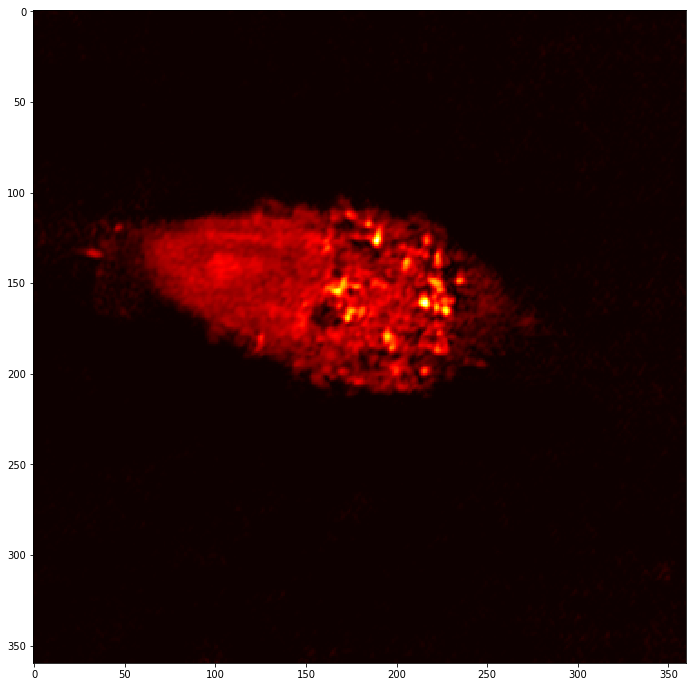

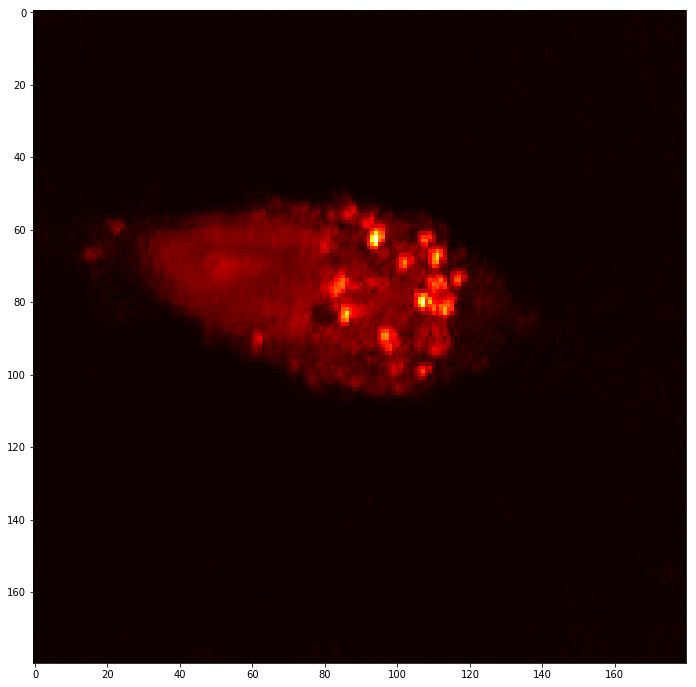

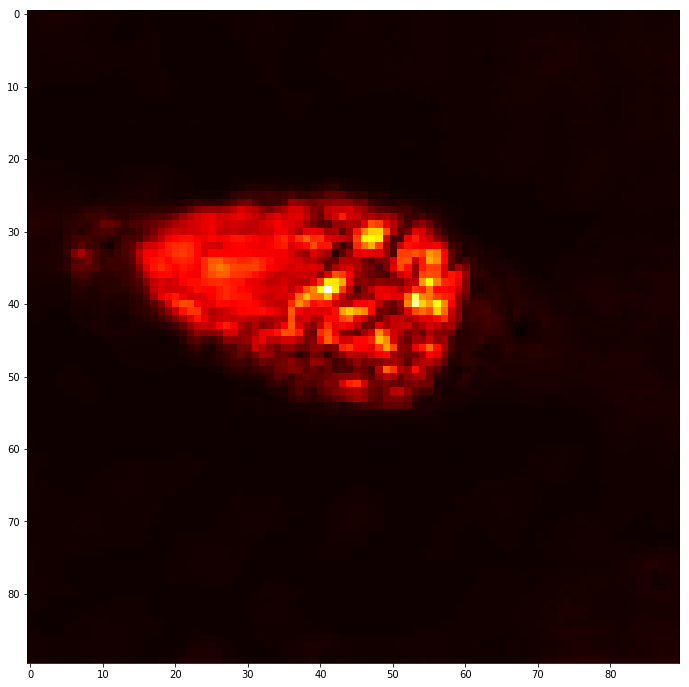

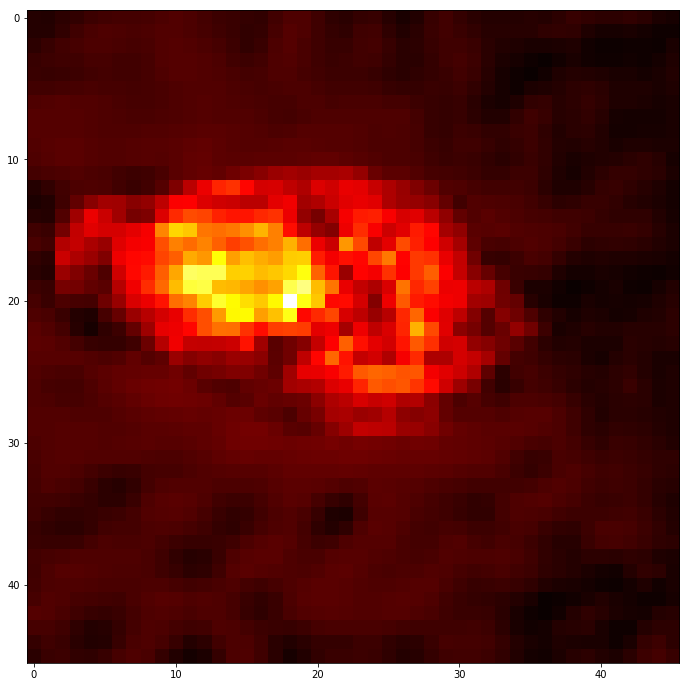

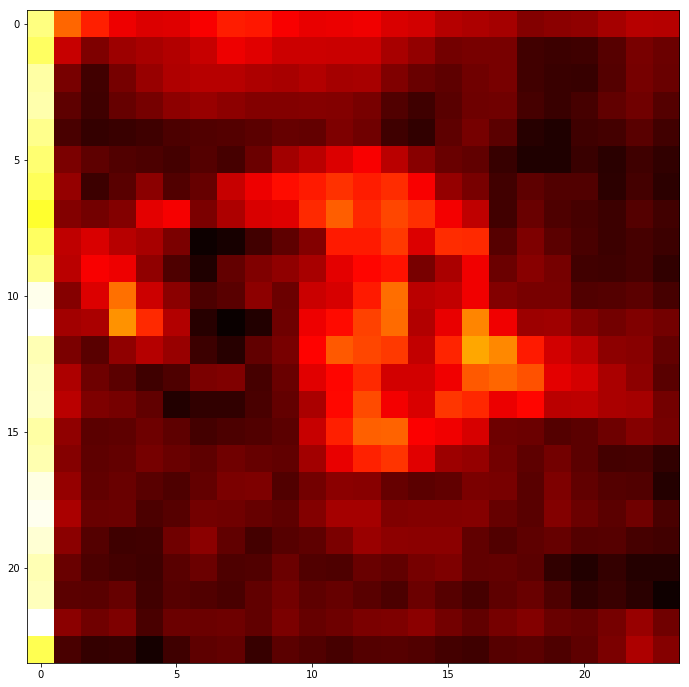

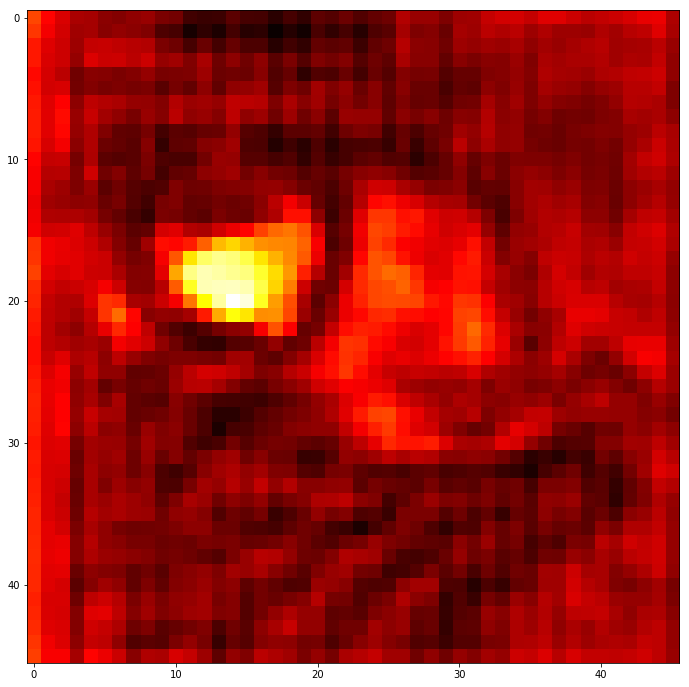

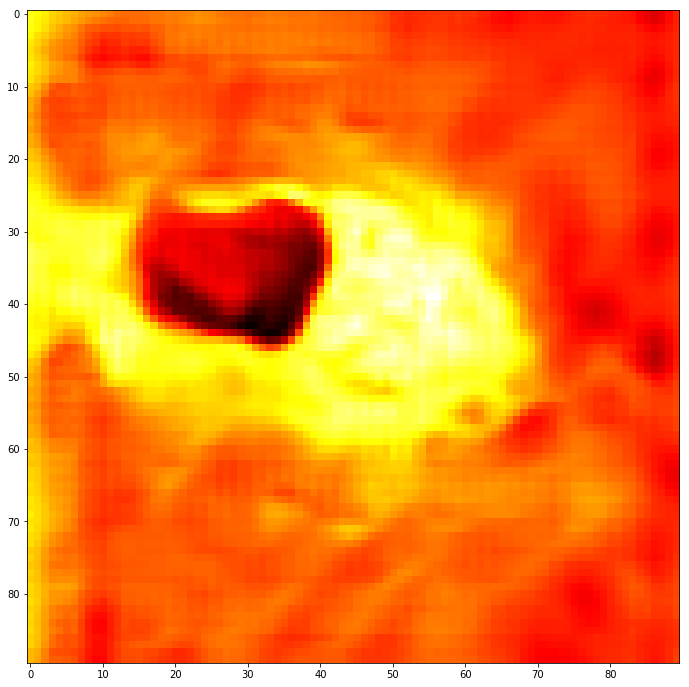

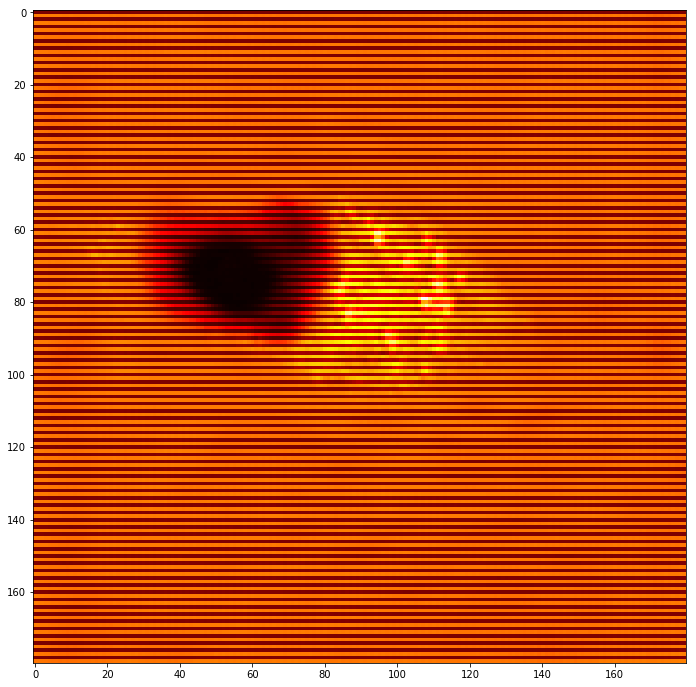

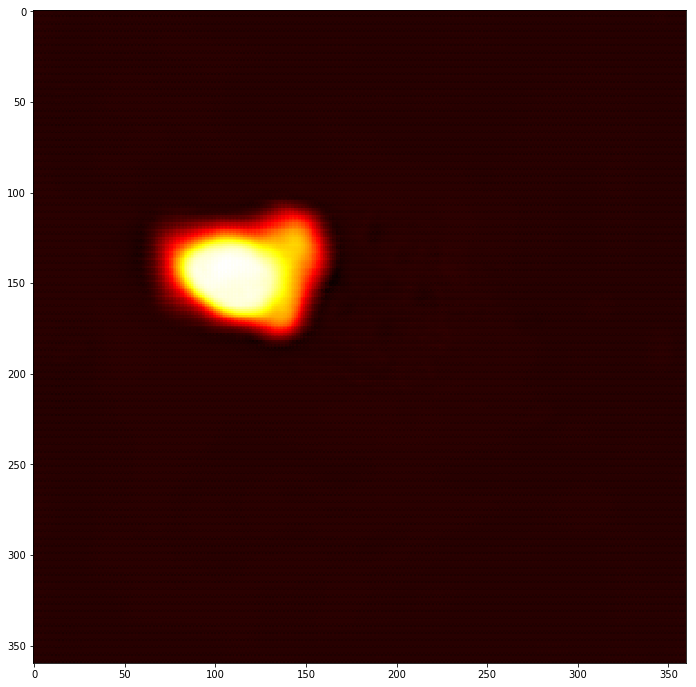

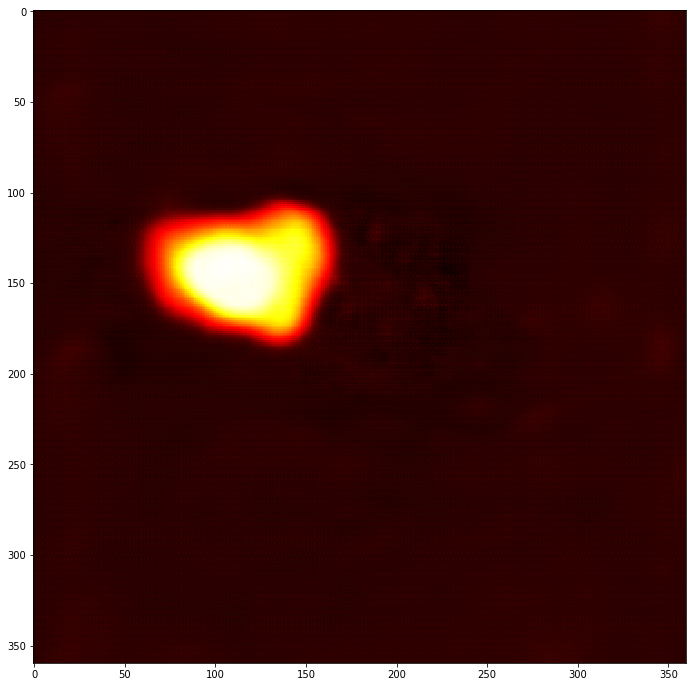

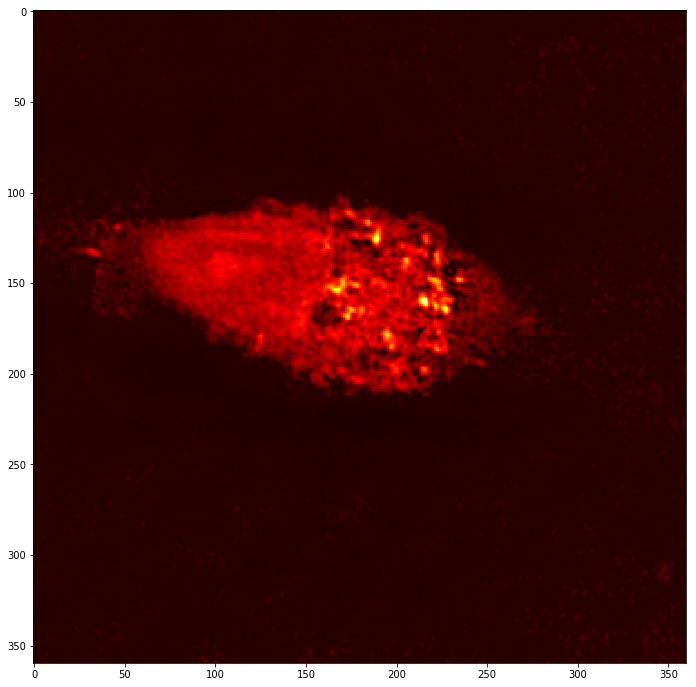

In [5]:
import matplotlib.pyplot as plt

for _, output in enumerate(model_outputs):
    if _ < len(model_outputs) - 1:
        img = 0
        for index in range(output.detach().numpy().shape[1]):
            img += output.detach().numpy()[0, index]
    else:
        img = i.detach().numpy()[0, 0]
    plt.figure(figsize=(12, 12))
    size = img.shape[0]
    margin = size // 10
    plt.imshow(img[margin:-margin, margin:-margin], cmap='hot')